In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [7]:
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup

In [8]:
from pybaseball import statcast

In [9]:
import lzma
import pickle

In [10]:
with lzma.open("../data/X_train.xz", "rb") as f:
    X_train = pickle.load(f)
with lzma.open("../data/X_test.xz", "rb") as f:
    X_test = pickle.load(f)
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [11]:
# check shapes
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((107897, 629), (35953, 629), (107897, 1), (35953, 1))

In [12]:
#  Reshape y_train and y_test
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [13]:
#  Check again for nulls
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

In [14]:
#  Calculate baseline scores
base = [np.mean(y_train)] * len(y_test)
mean_squared_error(y_test, base, squared = False)

2.441705718241977

In [15]:
#  Ultimately, we settled on using the framework of linear model, 
#  with l1 and l2 regularization provided through ElasticNet

#  The size of the dataset (over 100k pitches in only 5 weeks of a regular season)
#  made processing time and space unreasonable for many other models.

#  We attempted:
##    KNeighbors 
##    Decision Trees (faster, but too overfit)
##    Random Forest (better performance, but too slow to tune hyperparameters in gridsearch)
##    Neural networks (depths of 2-8 dense layers, widths of 32 - 1024)
##         these generally performed worse than regularized linear models on this regression problem
##         neural networks were more effective in several classification models we attempted before this model    
lr = LinearRegression()
lr.fit(X_train, y_train)
mean_squared_error(y_train, lr.predict(X_train), squared = False), mean_squared_error(y_test, lr.predict(X_test), squared = False)

(1.8401975157055588, 1093009845167.0112)

In [16]:
#  View first 50 coefs
lr.coef_[0:50]

array([-6.59165884e+12,  1.44379972e+12,  1.18085394e+10, -1.58253814e+11,
       -4.42764352e+11, -1.16784902e+12,  8.80368192e+11, -9.41624893e+11,
       -1.54998313e+12, -2.45400068e+12, -3.03522997e+12,  2.88415159e+12,
       -2.52502964e+11,  5.63978624e+11,  1.29905257e+11,  1.71581833e+11,
        4.57349076e+11, -4.47527940e+11,  1.12343092e+12, -3.38497639e+12,
        1.46408081e-02,  4.72640991e-03,  1.90937042e-01,  8.44993591e-02,
        1.59721375e-01,  9.90066528e-02,  9.01031494e-03,  3.93371582e-02,
        3.80625266e+11,  7.48065255e+09,  3.18460324e+11,  2.82319074e+10,
        5.28481336e+10,  3.30967684e+11,  5.72669501e+11,  3.62486806e+10,
        1.72945208e+11,  9.16180593e+09,  1.70796061e+11,  1.71389779e+10,
        4.38871004e+11,  4.70650419e+11,  2.55365354e+11,  8.41055410e+10,
       -2.71774336e+10, -7.64659969e+10, -7.21990998e+10, -5.75145470e+10,
       -6.45891295e+10, -1.82897703e+11])

In [12]:
##  Clearly, some regularization is needed -- the model is overfit, and some coefs are larger as 10^11.  

##  The following process allows us to explore more combinations of alpha and l1_ratio 
##  than a gridsearch in light of data size and processing speed 
##  before multiplying attempts by 5 with cross_validation.  

##  In other words, we want to see if our l1 and l2 regularization values are "in the ballpark"!

scores = []
for alpha in [0.01,0.1,1,2,5,10,100]:
    for l1_ratio in [0.001,0.01,0.1,0.25,0.5,0.99]:
        enet = ElasticNet(alpha = alpha,l1_ratio = l1_ratio)
        enet.fit(X_train,y_train)
        scores.append([enet.alpha,enet.l1_ratio,\
                 mean_squared_error(y_train, enet.predict(X_train), squared = False), \
                 mean_squared_error(y_test, enet.predict(X_test), squared = False)])

C:\Users\rob\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+05, tolerance: 6.430e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\rob\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+03, tolerance: 6.430e+01
  model = cd_fast.enet_coordinate_descent(


In [13]:
#  Collect scores into df and view lowest mses
df_scores = pd.DataFrame(scores, columns = ['alpha','l1_ratio','train','test'])
df_scores.sort_values(by = 'test').head()

,alpha,l1_ratio,train,test
24,5.0,0.001,2.272948,2.354153
30,10.0,0.001,2.351145,2.374807
25,5.0,0.010,2.368184,2.402234
19,2.0,0.010,2.190790,2.408056
18,2.0,0.001,2.124221,2.418006


In [16]:
#  Having seen the best scores from the last set, 
#  we "zoom in" on the region of values that had the best scores
scores_2 = []
for alpha in [3,4,5,6,8,10]:
    for l1_ratio in [0.001,0.002,0.005,0.01,0.02]:
        enet = ElasticNet(alpha = alpha,l1_ratio = l1_ratio)
        enet.fit(X_train,y_train)
        scores_2.append([enet.alpha,enet.l1_ratio,\
                 mean_squared_error(y_train, enet.predict(X_train), squared = False), \
                 mean_squared_error(y_test, enet.predict(X_test), squared = False)])

In [17]:
df_scores_2 = pd.DataFrame(scores, columns = ['alpha','l1_ratio','train','test'])
df_scores_2.sort_values(by = 'test').head()

,alpha,l1_ratio,train,test
24,5.0,0.001,2.272948,2.354153
30,10.0,0.001,2.351145,2.374807
25,5.0,0.010,2.368184,2.402234
19,2.0,0.010,2.190790,2.408056
18,2.0,0.001,2.124221,2.418006


In [17]:
#  These top 5 models at least marginally outperformed the baseline
#  Train and fit best estimator
enet = ElasticNet(alpha = 5, l1_ratio = 0.001)
enet.fit(X_train,y_train)

ElasticNet(alpha=5, l1_ratio=0.001)

In [19]:
#  Reassemble X and y for cross-val scoring
X = pd.concat([X_train,X_test], axis = 0)
y = pd.concat([y_train,y_test], axis = 0)
score = cross_val_score(enet, X, y, scoring = 'neg_mean_squared_error', cv = 5).mean()

In [20]:
score

-5.234717482584827

In [21]:
#  Score is negative squared error, multiply by -1 and take sqrt to get RMSE
(score * -1 ) ** 0.5

2.2879504982811203

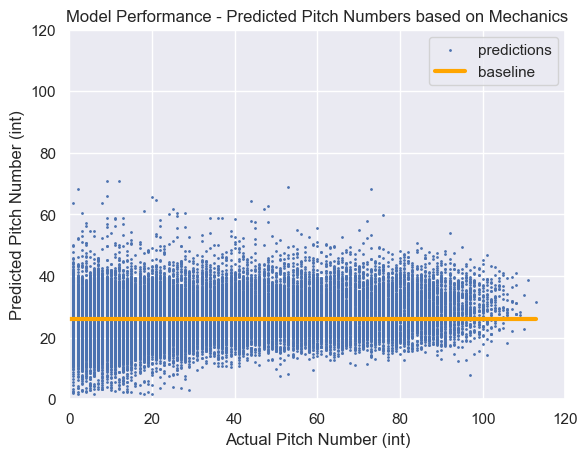

In [22]:
#  Compare predictions with actual values (square both to undo sqrt transform)
plt.scatter(y = (enet.predict(X_test)) ** 2, 
            x = (y_test) ** 2, 
            s = 1,
            label = 'predictions')
plt.plot([0,max(y_test) ** 2],[(np.mean(y_test)) ** 2,(np.mean(y_test)) ** 2], 
         linewidth = 3, linestyle = '-',color = 'orange',
        label = 'baseline')
plt.legend()
plt.title('Model Performance - Predicted Pitch Numbers based on Mechanics')
plt.ylabel('Predicted Pitch Number (int)')
plt.xlabel('Actual Pitch Number (int)')
plt.xlim(0,120)
plt.ylim(0,120);

Ultimately, this model performed only slightly better than the baseline.  Although the scoring improved with greater regularization, it appears that the model did not    With increased data, as well as the processing power and speed to train deep neural networks, this model can be improved significantly.

In [20]:
#  Save model to publish as app
filename = '../app/model.pkl'
pickle.dump(enet, open(filename, 'wb'))